# Metocean track comparison

Comparing MIKE 21 HD dfsu model result with satellite track observation of surface elevation. 

This notebook also includes gridded spatial skill assessments. 

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib_inline.backend_inline import set_matplotlib_formats
import modelskill as ms
set_matplotlib_formats('png')

## Extract track data

In [2]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ms.model_result(fn, name='HD', item=0)
mr

<DfsuModelResult>: HD
Time: 2017-10-27 00:00:00 - 2017-10-29 18:00:00
Quantity: Surface Elevation [m]

In this case, the track observations are stored in a csv file, which we can read in using pandas.
Any file format that can be read into a pandas dataframe can be used here.

In [3]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)

In [4]:
df.head()

,lon,lat,surface_elevation,significant_wave_height,wind_speed
date,,,,,
2017-10-26 04:37:37,8.757272,53.926136,1.6449,0.426,6.100000
2017-10-26 04:37:54,8.221631,54.948459,1.1200,1.634,9.030000
2017-10-26 04:37:55,8.189390,55.008547,1.0882,1.717,9.370000
2017-10-26 04:37:56,8.157065,55.068627,1.0309,1.869,9.559999
2017-10-26 04:37:58,8.124656,55.128700,1.0369,1.939,9.980000


In [5]:
mr.quantity

Quantity(name='Surface Elevation', unit='m')

In [6]:
# the dataframe doesn't include the metadata on which quantity it contains, we add this manually, consistent with the model result
o1 = ms.TrackObservation(df, item="surface_elevation", name='alti', quantity=ms.Quantity(name="Surface Elevation", unit="meter")) 
o1

/home/jan/src/modelskill/modelskill/timeseries/_track.py:136: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


<TrackObservation>: alti
Time: 2017-10-26 04:37:37 - 2017-10-30 20:54:47
Quantity: Surface Elevation [meter]

<Axes: title={'center': 'Spatial coverage'}>

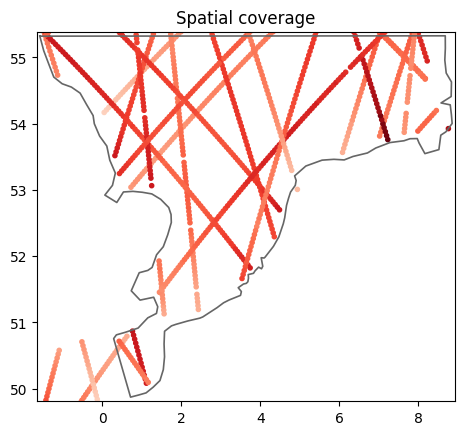

In [7]:
ms.plotting.spatial_overview(o1, mr)

In [8]:
cmp = ms.match(o1, mr)
cmp

<Comparer>
Quantity: Surface Elevation [meter]
Observation: alti, n_points=532
Model(s):
0: HD

In [9]:
cmp.data

<xarray.Dataset> Size: 19kB
Dimensions:      (time: 532)
Coordinates:
  * time         (time) datetime64[ns] 4kB 2017-10-27T10:45:19 ... 2017-10-29...
    x            (time) float64 4kB 1.262 1.231 1.2 1.168 ... 6.908 6.971 7.034
    y            (time) float64 4kB 55.3 55.24 55.18 55.13 ... 55.24 55.28 55.32
    z            float64 8B nan
Data variables:
    Observation  (time) float64 4kB 0.3778 0.4375 0.4489 ... 0.8368 0.8218
    HD           (time) float32 2kB 0.369 0.3644 0.3729 ... 0.7068 0.6986 0.6857
Attributes:
    gtype:               track
    modelskill_version:  1.1.dev0
    weight:              1.0
    name:                alti

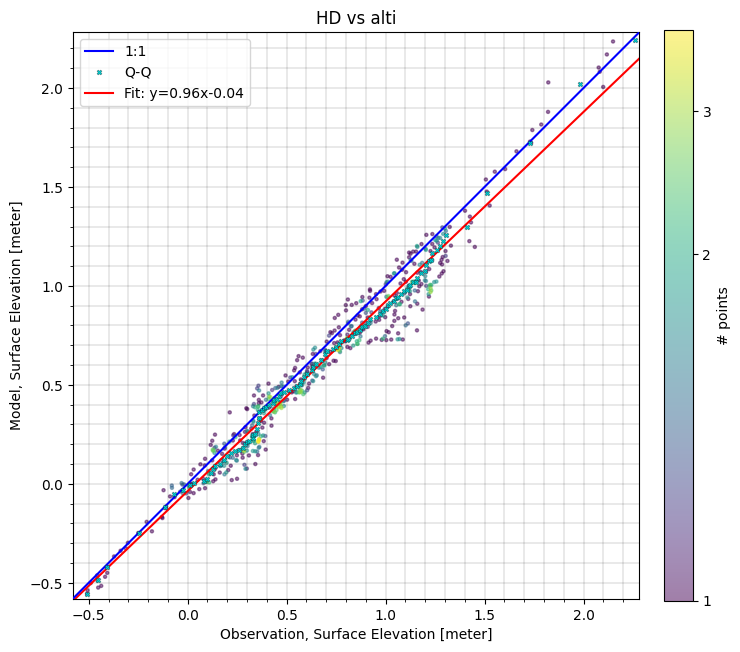

In [10]:
cmp.plot.scatter();

## Extract track from dfs0
ModelResult is now a dfs0

In [11]:
fn = '../tests/testdata/NorthSeaHD_extracted_track.dfs0'
mr = ms.TrackModelResult(fn, name='HD', item=2)  # explicitly define type as Track
mr.data

/home/jan/src/modelskill/modelskill/timeseries/_track.py:136: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


<xarray.Dataset> Size: 35kB
Dimensions:  (time: 1093)
Coordinates:
  * time     (time) datetime64[ns] 9kB 2017-10-26T04:37:37 ... 2017-10-30T20:...
    x        (time) float64 9kB 8.757 8.222 8.189 8.157 ... 3.64 3.609 3.577
    y        (time) float64 9kB 53.93 54.95 55.01 55.07 ... 55.48 55.54 55.59
    z        float64 8B nan
Data variables:
    HD       (time) float64 9kB nan nan nan nan nan nan ... nan nan nan nan nan
Attributes:
    gtype:               track
    modelskill_version:  1.1.dev0

In [12]:
mr

<TrackModelResult>: HD
Time: 2017-10-26 04:37:37 - 2017-10-30 20:54:47
Quantity: Undefined [undefined]

In [13]:
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = ms.TrackObservation(df, item=2, name='alti')

/home/jan/src/modelskill/modelskill/timeseries/_track.py:136: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


In [14]:
o1.data

<xarray.Dataset> Size: 35kB
Dimensions:  (time: 1093)
Coordinates:
    x        (time) float64 9kB 8.757 8.222 8.189 8.157 ... 3.64 3.609 3.577
    y        (time) float64 9kB 53.93 54.95 55.01 55.07 ... 55.48 55.54 55.59
  * time     (time) datetime64[ns] 9kB 2017-10-26T04:37:37 ... 2017-10-30T20:...
    z        float64 8B nan
Data variables:
    alti     (time) float64 9kB 1.645 1.12 1.088 1.031 ... 0.0364 0.0283 0.0601
Attributes:
    gtype:               track
    modelskill_version:  1.1.dev0
    weight:              1.0

In [15]:
cmp = ms.match(o1, mr)

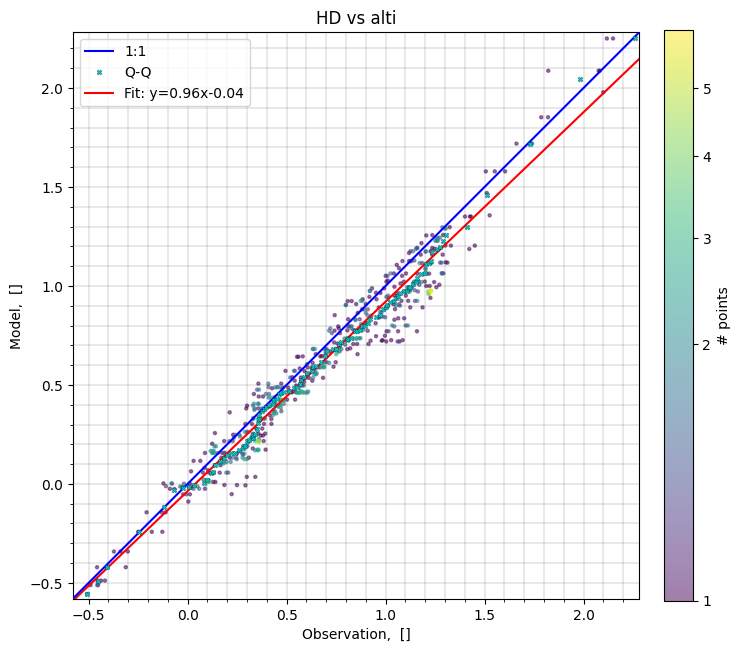

In [16]:
cmp.plot.scatter();

## Gridded skill

Load model, load observation, add observation to model and extract.

In [17]:
fn = '../tests/testdata/NorthSeaHD_and_windspeed.dfsu'
mr = ms.model_result(fn, name='HD', item=0)
fn = '../tests/testdata/altimetry_NorthSea_20171027.csv'
df = pd.read_csv(fn, index_col=0, parse_dates=True)
o1 = ms.TrackObservation(df, item=2, name='alti')
cmp = ms.match(o1, mr)
cmp

/home/jan/src/modelskill/modelskill/timeseries/_track.py:136: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


<Comparer>
Quantity:  []
Observation: alti, n_points=532
Model(s):
0: HD

Get metrics binned by a regular spatial grid, returns xarray Dataset

In [18]:
gs = cmp.gridded_skill(metrics=['bias'])

In [19]:
gs['n'].data

<xarray.DataArray 'n' (y: 5, x: 5)> Size: 200B
array([[ 3, 17,  0,  0,  0],
       [ 0, 49,  9,  0,  0],
       [ 0, 34, 51,  0,  0],
       [13, 70, 33, 15, 27],
       [37, 79,  0, 20, 75]])
Coordinates:
  * y            (y) float64 40B 50.6 51.66 52.7 53.75 54.8
  * x            (x) float64 40B -0.436 1.543 3.517 5.492 7.466
    observation  <U4 16B 'alti'
Attributes:
    long_name:  Number of observations
    units:      -

Plot using xarray - convenient methods coming soon!

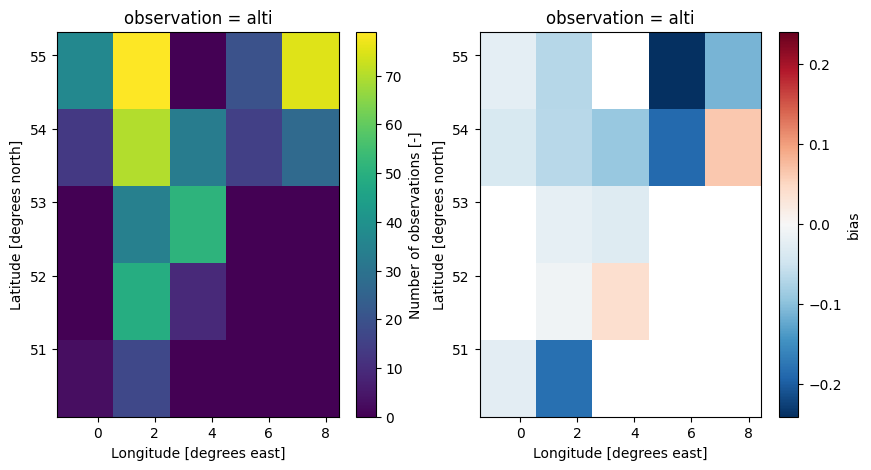

In [20]:
fig, axes = plt.subplots(ncols=2, nrows=1, figsize = (10, 5))
gs.n.plot(ax=axes[0])
gs.bias.plot(ax=axes[1]);

## Minimum number of observations

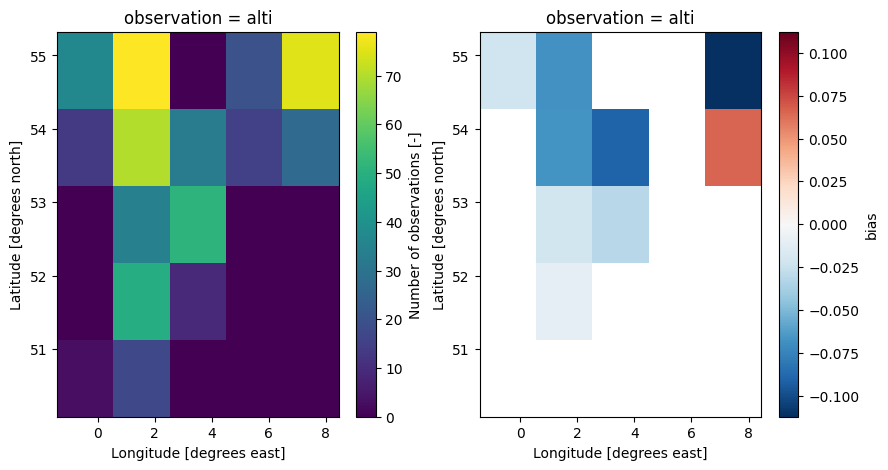

In [21]:
gs = cmp.gridded_skill(metrics=['bias'], n_min=25)
fig, axes = plt.subplots(ncols=2, nrows=1, figsize=(10, 5))
gs.n.plot(ax=axes[0])
gs.bias.plot(ax=axes[1]);

## Multiple bins - gridded skill for water level categories

Get data from comparer as dataframe and add a water level category as a new column.

In [22]:
dftmp = cmp.data.to_dataframe()
dftmp["wl category"] = 'high'
dftmp.loc[dftmp['HD']<0, "wl category"] = 'low'

Add the "wl category" to the comparer's data structure.

In [23]:
cmp.data["wl category"] = dftmp["wl category"]
cmp.data

<xarray.Dataset> Size: 23kB
Dimensions:      (time: 532)
Coordinates:
  * time         (time) datetime64[ns] 4kB 2017-10-27T10:45:19 ... 2017-10-29...
    x            (time) float64 4kB 1.262 1.231 1.2 1.168 ... 6.908 6.971 7.034
    y            (time) float64 4kB 55.3 55.24 55.18 55.13 ... 55.24 55.28 55.32
    z            float64 8B nan
Data variables:
    Observation  (time) float64 4kB 0.3778 0.4375 0.4489 ... 0.8368 0.8218
    HD           (time) float32 2kB 0.369 0.3644 0.3729 ... 0.7068 0.6986 0.6857
    wl category  (time) object 4kB 'high' 'high' 'high' ... 'high' 'high' 'high'
Attributes:
    gtype:               track
    modelskill_version:  1.1.dev0
    weight:              1.0
    name:                alti

Now aggregate the data by the new column (and x and y):

In [24]:
gs = cmp.gridded_skill(by=['wl category'], metrics=['bias'], n_min=5)
gs

<SkillGrid>
Dimensions: (x: 5, y: 5)

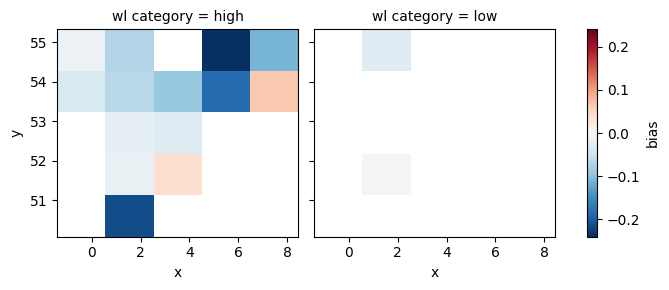

In [25]:
gs.bias.plot();

## Multiple observations

Add fake 2nd observation to model

In [26]:
import warnings

df2 = df.copy()
df2['surface_elevation'] = df2['surface_elevation'] - 0.2
o2 = ms.TrackObservation(df2, item=2, name='alti2')

warnings.filterwarnings('ignore', message="duplicate")
cmp2 = ms.match(o2, mr)

/home/jan/src/modelskill/modelskill/timeseries/_track.py:136: UserWarning: Removed 22 duplicate timestamps with keep=first
  warnings.warn(


Extract, gridded skill, add attrs, plot.

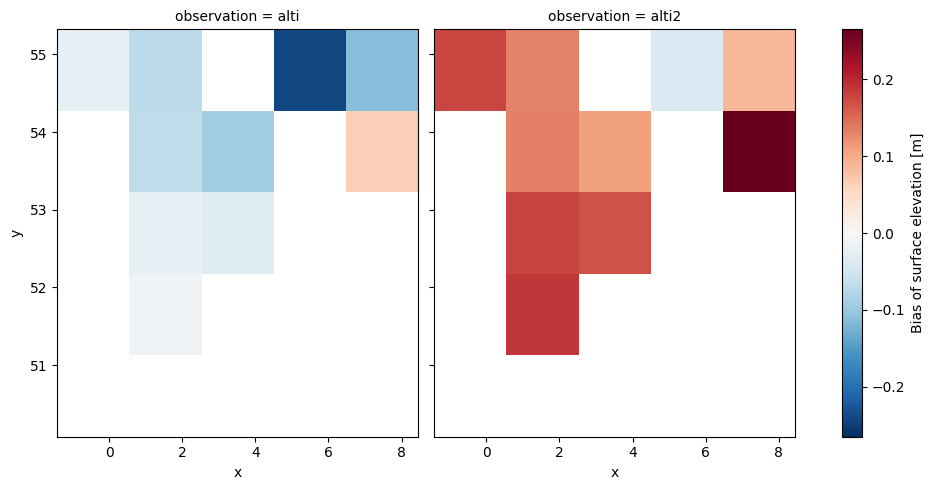

In [27]:
cmp = cmp + cmp2
gs = cmp.gridded_skill(metrics=['bias'], n_min=20)
gs.bias.data.attrs = dict(long_name="Bias of surface elevation", units="m")
gs.bias.plot(figsize=(10,5));